In [53]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os, sys, time
sys.path.append('../laba')
%matplotlib inline
from RegexParser import RegexParser
from SMCParser import SMCParser
from LexParser import LexParser


In [54]:
def test(laba, fileName='./timing.txt', splits_num=10, iters=50):
  pd_res = None
  with open(fileName, 'r', encoding='UTF-8') as inp:
    for i, line in enumerate(inp):
      pass
    lines_num = i+1

    splits = np.linspace(0, lines_num, splits_num)[1:]
    lines = inp.readlines()

    for sp in splits:
      a = []
      ed = int(sp)
      for j in range(iters):
        start = time.time_ns()
        for line in lines[:ed]:
          laba.parse(line)
        end = time.time_ns()
        a.append(end-start)

      res = {f'{ed}':a}
      tmp = pd.DataFrame.from_dict(res)
    
      
      if pd_res is None:
        pd_res = tmp
      else:
        pd_res = pd.concat([pd_res, tmp], axis=1)
  return pd_res
        


In [55]:
smc = SMCParser()
regex = RegexParser()
lex = LexParser().build()

In [56]:
def graph(pds, names, name=''):
  plt.style.use('dark_background')
  fig = plt.figure(figsize=(10,5))
  for i, p in enumerate(pds):
    means = p[1:].mean()
    x = means.index
    plt.scatter(x, means, label=names[i], cmap=i)
    plt.plot(x, means)
  fig.legend()
  plt.ylabel('ns')
  plt.xlabel('rows')
  plt.title(name)

In [57]:
testFiles = sorted([i for i in os.listdir('../tests') if i.split('.')[-1] == 'test'])
testFiles

['03_10_2021_00_26_27__10000__20.test',
 '03_10_2021_00_26_34__10000__50.test',
 '03_10_2021_00_26_42__10000__100.test',
 '03_10_2021_00_26_51__10000__200.test',
 '03_10_2021_00_27_06__10000__500.test',
 '03_10_2021_00_31_11__10000__1000.test',
 'test1.test',
 'test2.test']

In [58]:
selectedTests = lambda i: (os.path.join('../tests/', testFiles[i]),lambda x: test(x, fileName=os.path.join('../tests/', testFiles[i])))

In [59]:
def doTest(i):
  labas = [smc, regex, lex]
  names = ['smc', 'regex', 'lex']
  name, testik = selectedTests(i)
  pds = list(map(testik, labas))
  graph(pds, names, name)

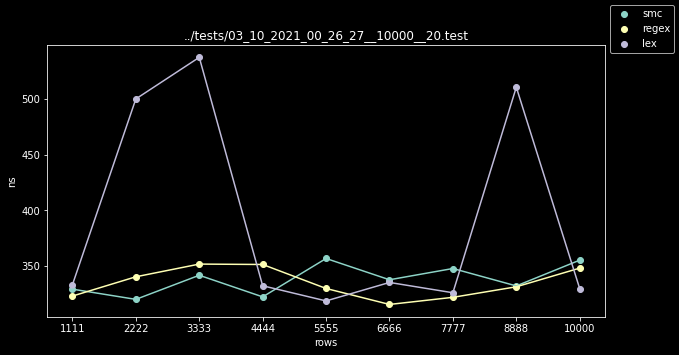

In [102]:
doTest(0)

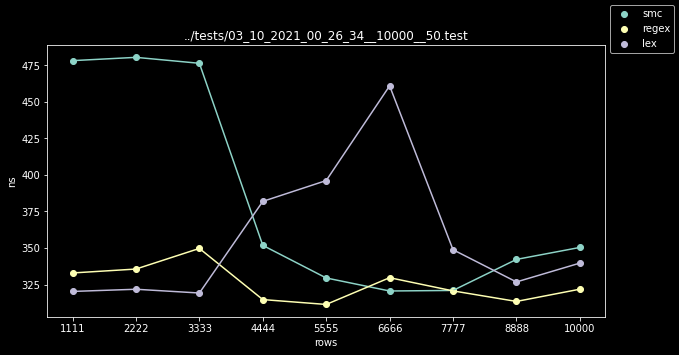

In [101]:
doTest(1)

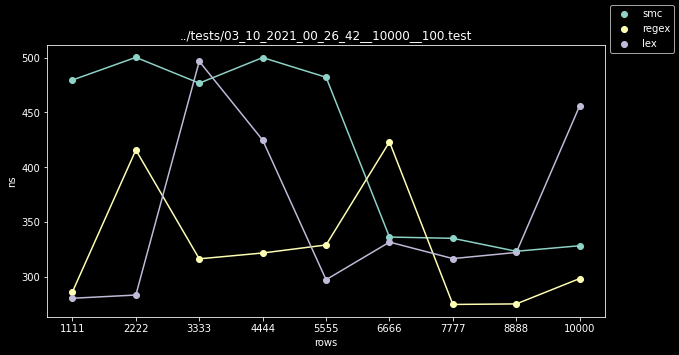

In [91]:
doTest(2)

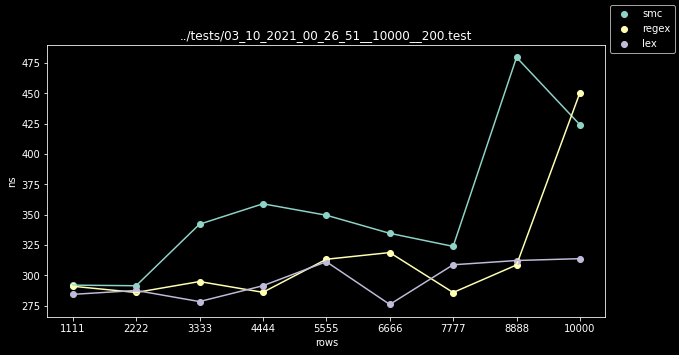

In [63]:
doTest(3)

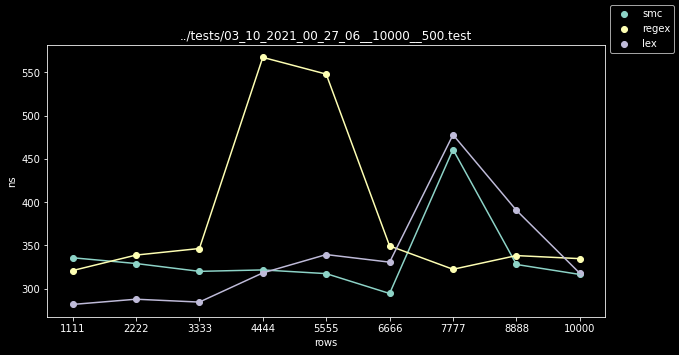

In [64]:
doTest(4)

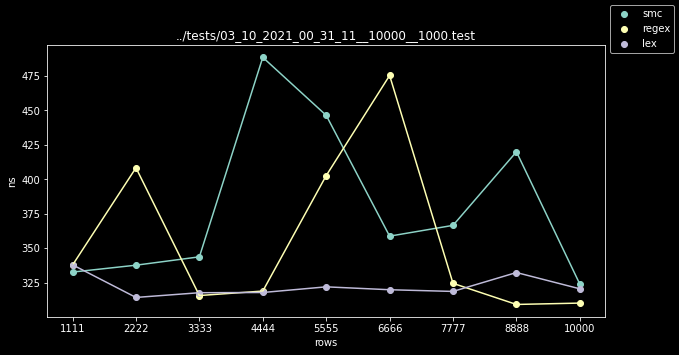

In [68]:
doTest(5)